In [9]:
import pandas as pd
import glob

First, we define a design matrix for the model.
As the model is trivial (one-sample test), the design matrix is just one column with ones.

In [25]:
data = glob.glob('/Volumes/QCI/ZY_SeedFC/zy_seedFC_rightAmygdala_MDD135/*.nii.gz')
second_level_input = data
design_matrix = pd.DataFrame(
    [1] * len(second_level_input),
    columns=["intercept"],
)

Next, we specify and estimate the model.

In [26]:
from nilearn.glm.second_level import SecondLevelModel

second_level_model = SecondLevelModel(n_jobs=2).fit(
    second_level_input, design_matrix=design_matrix
)
print(second_level_model)

EOFError: Compressed file ended before the end-of-stream marker was reached

Compute the only possible contrast: the one-sample test. Since there is only one possible contrast,
we don’t need to specify it in detail.

In [27]:
z_map = second_level_model.compute_contrast(output_type="z_score")

Threshold the resulting map without multiple comparisons correction, abs(z) > 3.29 (equivalent to p < 0.001), cluster size > 10 voxels.

In [28]:
from nilearn.image import threshold_img

threshold_img(
    z_map,
    threshold=3.29,
    cluster_threshold=10,
    two_sided=True,

)

/var/folders/dh/dmftg40j21j249nqf2z5v2nh0000gn/T/ipykernel_64166/4157676921.py:3: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  threshold_img(


This is equivalent to thresholding a z-statistic image with a false positive rate < .001, cluster size > 10 voxels.

In [29]:
from nilearn.glm import threshold_stats_img

thresholded_map1, threshold1 = threshold_stats_img(
    z_map,
    alpha=0.001,
    height_control="fpr",
    cluster_threshold=10,
    two_sided=True,
)

Now use FDR <.05 (False Discovery Rate) and no cluster-level threshold.

In [30]:
thresholded_map2, threshold2 = threshold_stats_img(
    z_map, alpha=0.05, height_control="fdr"
)
print(f"The FDR=.05 threshold is {threshold2:.3g}")

The FDR=.05 threshold is 2.11


In [31]:
import nibabel as nib
nib.save(thresholded_map2, '/Users/qingchen/Documents/code/ToolBox/data_processing/FCTtest/zy_seedFC_rightAmygdala_MDD135.nii')

Now use FWER <.05 (Family-Wise Error Rate) and no cluster-level threshold.
As the data has not been intensively smoothed, we can use a simple Bonferroni correction.

In [21]:
thresholded_map3, threshold3 = threshold_stats_img(
    z_map, alpha=0.05, height_control="bonferroni"
)
print(f"The p<.05 Bonferroni-corrected threshold is {threshold3:.3g}")

The p<.05 Bonferroni-corrected threshold is 5.15


First, the unthresholded map.

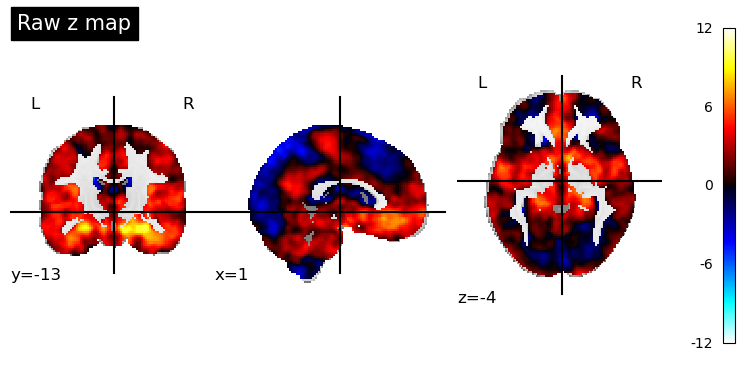

In [22]:
from nilearn import plotting

display = plotting.plot_stat_map(z_map, title="Raw z map")

Second, the p<.001 uncorrected-thresholded map (with only clusters > 10 voxels).

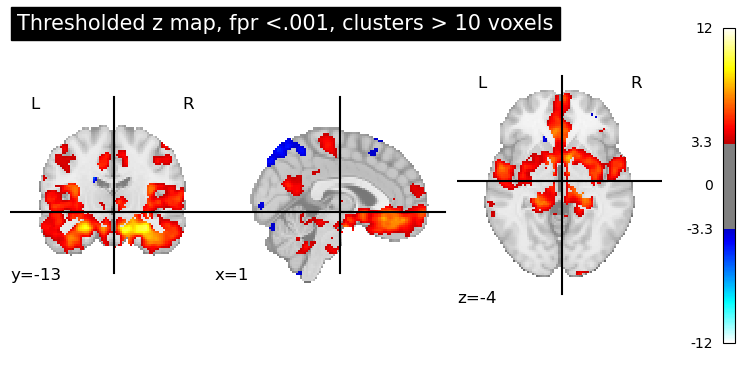

In [23]:
plotting.plot_stat_map(
    thresholded_map1,
    cut_coords=display.cut_coords,
    threshold=threshold1,
    title="Thresholded z map, fpr <.001, clusters > 10 voxels",
)

Third, the fdr-thresholded map.

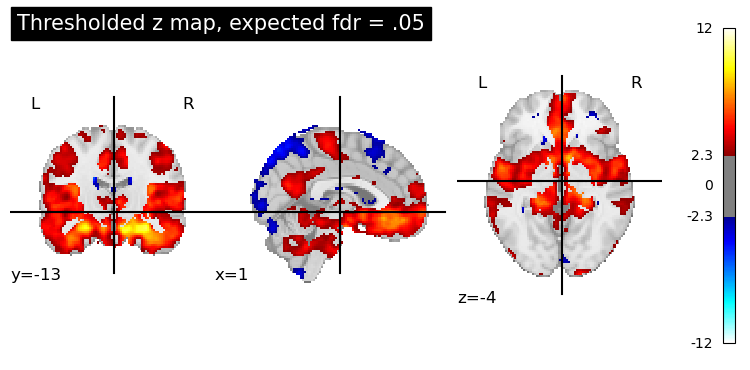

In [24]:
plotting.plot_stat_map(
    thresholded_map2,
    cut_coords=display.cut_coords,
    title="Thresholded z map, expected fdr = .05",
    threshold=threshold2,
)

Fourth, the Bonferroni-thresholded map.

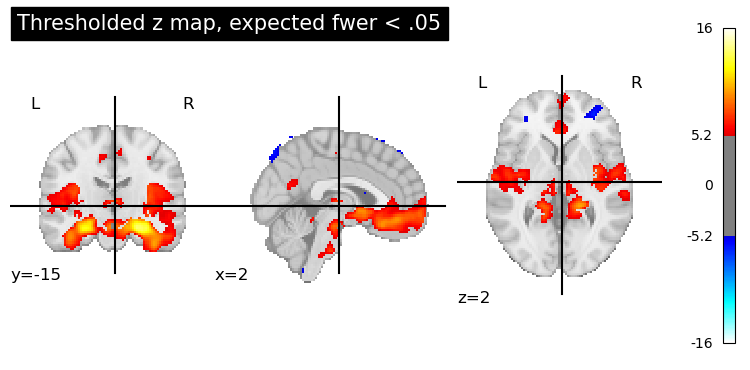

In [13]:
plotting.plot_stat_map(
    thresholded_map3,
    cut_coords=display.cut_coords,
    title="Thresholded z map, expected fwer < .05",
    threshold=threshold3,
)